In [2]:
import collections
import itertools
import os
import re
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.preprocessing import text
from tensorflow.keras import utils

# Hyper parameters
top_n = 10
batch_size = 32
epochs = 5
k = 10

In [4]:
# load data 
total = pd.read_csv('listings.csv', low_memory=False)
print(total.shape)
cols = ['id','name','description','summary','amenities']
total = total[cols]
total.columns
total.head()

(22895, 84)


id                                              name  \
0   9835                            Beautiful Room & House   
1  10803          Room in Cool Deco Apartment in Brunswick   
2  12936  St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC   
3  15246                  Large private room-close to city   
4  16760                  Melbourne BnB near City & Sports   

                                         description  \
0  House: Clean, New, Modern, Quite, Safe. 10Km f...   
1  A large air conditioned room with queen spring...   
2  RIGHT IN THE HEART OF ST KILDA! It doesn't get...   
3  Comfortable, relaxed house, a home away from  ...   
4  We offer comfortable accommodation in Inner Me...   

                                             summary  \
0                                                NaN   
1  A large air conditioned room with queen spring...   
2  RIGHT IN THE HEART OF ST KILDA! It doesn't get...   
3  Comfortable, relaxed house, a home away from  ...   
4                                                NaN   

                                           amenities  
0  {Internet,Wifi,"Pets live on this property",Do...  
1  {TV,Internet,Wifi,"Air conditioning",Kitchen,H...  
2  {TV,Internet,Wifi,"Air conditioning",Kitchen,"...  
3  {TV,Internet,Wifi,Kitchen,"Free parking on pre...  
4  {Internet,Wifi,Heating,Washer,"Smoke detector"...

In [5]:
# inspect amenities
total.amenities.value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### Data Preprocessing

In [6]:
# data cleaning
df = total.amenities.str.replace('{', '').str.replace('}','').str.replace('"','') \
    .str.split(',').apply(pd.Series) \
    .merge(total, left_index = True, right_index = True) \
    .drop(["amenities"], axis = 1) \
    .melt(id_vars = ['id','name', 'description'], value_name = "amenity") \
    .drop("variable", axis = 1) \
    .dropna()

#  identify short invalid amenities
amenity_filter_short = (df['amenity'].astype(str).str.len()<=2) & (df['amenity'].astype(str) != 'TV')
sdf = df[~amenity_filter_short]

# remove invalid short amenities
df.drop(df[amenity_filter_short].index, inplace=True)

print(df.shape)

# filter non-ascii characters
df['amenity'] = df['amenity'].apply(lambda x: ''.join(i for i in x if ord(i)<128))
df['description'] = df['description'].apply(lambda x: ''.join(i for i in x if ord(i)<128))

filter_invalid_amenity =  df.apply(lambda x: x.amenity[0:5] in x.description, axis=1)
df = df[~(filter_invalid_amenity)]
df.dropna(inplace=True)

print(df.shape)

filter_invalid_chars = df['amenity'].str.contains('[?#!.,_~")()]')
df.drop(df[(filter_invalid_chars==True)].index, inplace=True)

print(df.shape)
df.head()

(590058, 4)
(549530, 4)
(543567, 4)


id                                               name  \
1  10803           Room in Cool Deco Apartment in Brunswick   
4  16760                   Melbourne BnB near City & Sports   
6  41836                  CLOSE TO CITY & MELBOURNE AIRPORT   
7  43414                                   Home In The City   
8  43429  Tranquil Javanese-Style Apartment in Oakleigh ...   

                                         description   amenity  
1  A large air conditioned room with queen spring...        TV  
4  We offer comfortable accommodation in Inner Me...  Internet  
6  Easy to travel from and to the Airport; quiet ...        TV  
7  Comfortable and spacious room in an apartment ...        TV  
8  Study the exquisite detail of the antique Java...        TV

## Exploratory Data Analysis

In [7]:
# what are the most popular amenities (top 10)
popdf = df[['amenity','id']].groupby('amenity').count().sort_values(['id'], ascending=False).iloc[0:top_n,:]
popdf['amenity'] = popdf.index
popdf.columns = ['count','amenity']
popdf.set_index('count', inplace=True)
popdf['count'] = popdf.index

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(y='amenity',x='count', data=popdf)


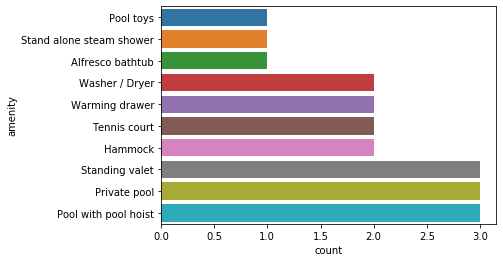

In [8]:
# what are the most popular amenities (top 10)
leastdf = df[['amenity','id']].groupby('amenity').count().sort_values(['id'], ascending=True).iloc[0:top_n,:]
leastdf['amenity'] = leastdf.index
leastdf.columns = ['count','amenity']
leastdf.set_index('count', inplace=True)
leastdf['count'] = leastdf.index

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(y='amenity',x='count', data=leastdf)


In [9]:
# Limit our dataset to only the top 10
print(df.count())
df = df[(df.amenity.isin(popdf.amenity))]
print(df.count())


id             543567
name           543567
description    543567
amenity        543567
dtype: int64
id             189834
name           189834
description    189834
amenity        189834
dtype: int64


In [10]:
# check if we have an even distribution of tags
df.amenity.value_counts()

Essentials          21170
Smoke detector      20520
Washer              19863
Kitchen             19699
Wifi                19663
Heating             19337
Hangers             18944
Air conditioning    16931
Shampoo             16855
Iron                16852
Name: amenity, dtype: int64

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zelda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


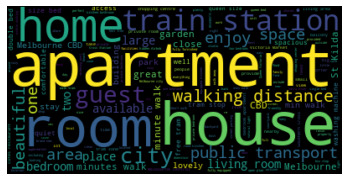

In [11]:
# sent_tokenize

# take the first 100 sentences
text = [w for sentence in df.iloc[0:3000].description for w in word_tokenize(sentence) if not w in stop_words]
wordcloud = WordCloud().generate(' '.join(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [13]:
def plot_tags(tagCount):
    """
    Helper function to plot tags
    """
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/4000 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(10,6))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()

[('Essentials', 21170), ('Smoke detector', 20520), ('Washer', 19863), ('Kitchen', 19699), ('Wifi', 19663), ('Heating', 19337), ('Hangers', 18944), ('Air conditioning', 16931), ('Shampoo', 16855), ('Iron', 16852)]


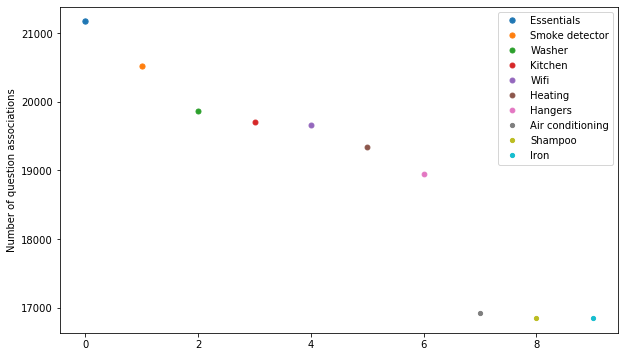

In [14]:
tagCount =  collections.Counter(list(df['amenity'])).most_common(10)
print(tagCount)
plot_tags(tagCount)

## Neural Network

In [17]:
def build_model(vocab_size, num_classes):
    
    # Build the model
    model = Sequential()
    model.add(Dense(512, input_shape=(vocab_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [18]:
# train and test 
skf = StratifiedKFold(n_splits=k)
t = df.amenity
for train_index, test_index in skf.split(np.zeros(len(t)), t):
    train = df.loc[train_index]
    test = df.loc[test_index]
    
    # drop any na's
    train.dropna(inplace=True)
    test.dropna(inplace=True)

    # assign fields
    train_posts = train.description
    train_tags = train.amenity
    test_posts = test.description
    test_tags = test.amenity
    
    vocab_size = 1000
    tokenize = text.Tokenizer(num_words=vocab_size)
    tokenize.fit_on_texts(train_posts)

    x_train = tokenize.texts_to_matrix(train_posts)
    x_test = tokenize.texts_to_matrix(test_posts)

    # convert label strings
    encoder = LabelEncoder()
    encoder.fit(train_tags)
    y_train = encoder.transform(train_tags)
    y_test = encoder.transform(test_tags)
    
    # convert to one-hot encoding
    num_classes = np.max(y_train) + 1
    y_train = utils.to_categorical(y_train, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)
    
    # build model
    model = build_model(vocab_size, num_classes)
    
    # train model
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_split=0.1)
    
    # Evaluatemodel
    score = model.evaluate(x_test, y_test,
                           batch_size=batch_size, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.5460689398732288
Test accuracy: 0.22607428


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.5939211234140156
Test accuracy: 0.22803716


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.6640443236356535
Test accuracy: 0.21221755


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.7184917800273658
Test accuracy: 0.19629021


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.7865907105801435
Test accuracy: 0.19917299


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.9193277767896788
Test accuracy: 0.18435119


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 1.968179381945554
Test accuracy: 0.157284


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 2.2017481780285024
Test accuracy: 0.14115375


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 2.2058121566290323
Test accuracy: 0.13118327


C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\zelda\Anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


Test score: 2.3993670810880787
Test accuracy: 0.121030554


In [19]:
# generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")
    print('p:',np.argmax(prediction))
    print('np',np.array([x_test[i]]))

Welcome to 5 star luxury in the heart of St Kilda. ...
Actual label:Wifi
Predicted label: Kitchen

p: 5
np [[0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 

np [[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 

In [20]:
# use trained NN to make predicition

y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Helper function to generate confusion matrix
    """
 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

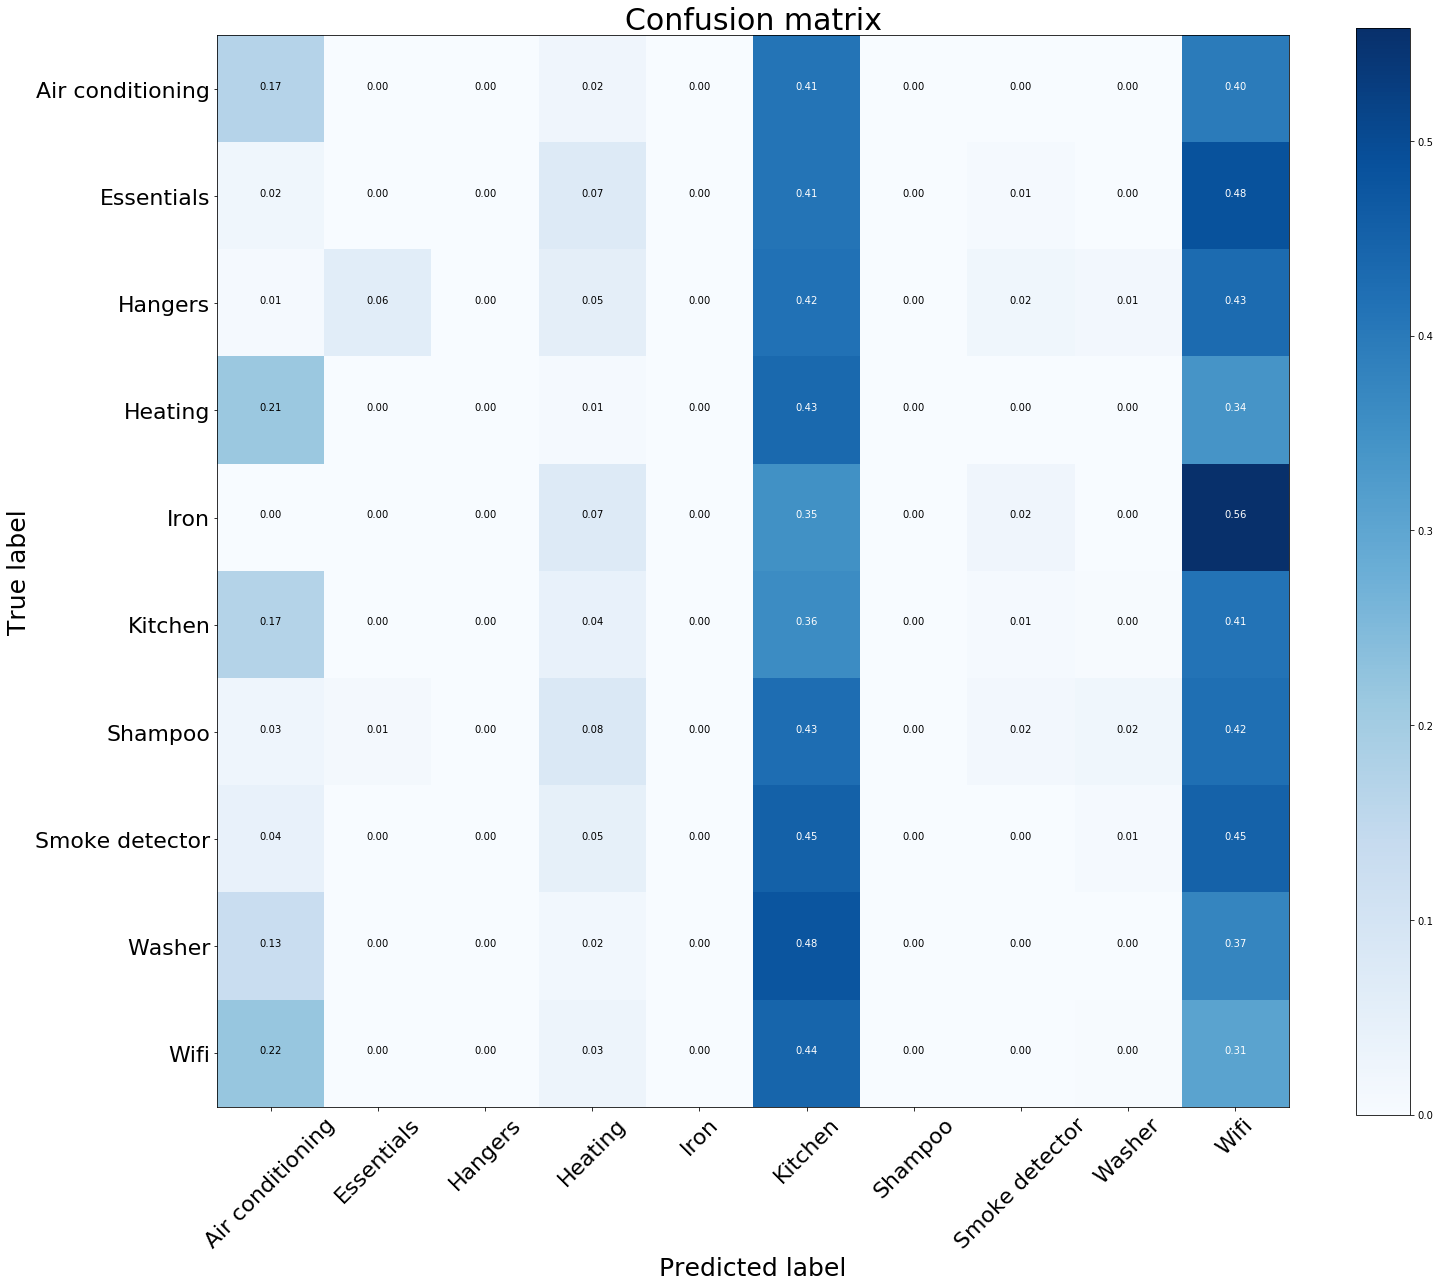

In [22]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()